In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer # To handle missing metadata
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model # Use Functional API
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    concatenate, # To merge branches
)
from tensorflow.data import AUTOTUNE

# --- Explainability Imports ---
from tf_explain.utils.display import grid_display
from tf_explain.utils.image import transform_to_normalized_grayscale
import shap
from shap import KernelExplainer
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)
# Optional: Check GPU again in the new notebook
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPUs found and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not found. Using CPU.")

TensorFlow Version: 2.10.1
1 Physical GPUs found and configured.


C:\Users\Carmine\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Paths ---
BASE_FOLDER = "."
ORIGINAL_FOLDER = os.path.join(BASE_FOLDER, "original_datasets")
PROCESSED_FOLDER = os.path.join(BASE_FOLDER, "processed_datasets")
IMAGE_FOLDER = os.path.join(ORIGINAL_FOLDER, "images_gz2", "images")
LABEL_FILE = os.path.join(PROCESSED_FOLDER, "gz2_simplified_labels.csv")
MAPPING_FILE = os.path.join(ORIGINAL_FOLDER, "gz2_filename_mapping.csv")
METADATA_FILE = os.path.join(ORIGINAL_FOLDER, "gz2sample.csv")

# --- Explainability ---
EXPLAIN_OUTPUT_DIR = "explainability_maps"

# --- Parameters ---
NUM_IMAGES_TO_USE = 239692
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 15
VALIDATION_SPLIT = 0.2

# --- Class Handling ---
CLASSES_TO_EXCLUDE = ["Artifact"] # Exclude low-count classes

# --- Metadata Columns to Use ---
# Selected numerical columns from gz2sample.csv headers provided
METADATA_COLS = [
    'PETROR50_R',     # Petrosian radius (50% light) in r-band (arcsec)
    'PETROR90_R',     # Petrosian radius (90% light) in r-band (arcsec)
    'FRACDEV_R',      # Fraction of light best fit by de Vaucouleurs profile
    'REDSHIFT',       # Spectroscopic redshift (usually 'z' or 'specz')
    'PETROMAG_MU',    # Absolute Petrosian magnitude in u-band
    'PETROMAG_MG',    # Absolute Petrosian magnitude in g-band
    'PETROMAG_MR',    # Absolute Petrosian magnitude in r-band
    'PETROMAG_MI',    # Absolute Petrosian magnitude in i-band
    'PETROMAG_MZ',    # Absolute Petrosian magnitude in z-band
    'PETROR50_R_KPC', # Petrosian radius (50% light) in kiloparsecs
]

In [3]:
# --- Load Labels ---
try:
    labels_df = pd.read_csv(LABEL_FILE)
    labels_df["dr7objid"] = labels_df["dr7objid"].astype(str)
    print(f"Loaded labels for {len(labels_df)} galaxies.")
except FileNotFoundError:
    print(f"ERROR: Label file not found at {LABEL_FILE}")
    raise

# --- Load Mapping ---
try:
    mapping_df = pd.read_csv(MAPPING_FILE)
    mapping_df = mapping_df.rename(
        columns={"objid": "dr7objid", "asset_id": "image_filename_base"}
    )
    # Convert mapping ID robustly
    mapping_df["dr7objid"] = (
        mapping_df["dr7objid"].astype(str)
    )
    print(f"Loaded mapping for {len(mapping_df)} files.")
except FileNotFoundError:
    print(f"ERROR: Mapping file not found at {MAPPING_FILE}")
    raise
except Exception as e:
    print(f"Error loading/processing mapping file: {e}")
    raise

# --- Load Metadata ---
try:
    metadata_df = pd.read_csv(METADATA_FILE)
    # Ensure metadata ID is string for merging
    metadata_df["dr7objid"] = metadata_df["dr7objid"].astype(str)
    print(f"Loaded metadata for {len(metadata_df)} galaxies.")
    # Check if selected metadata columns exist
    missing_meta_cols = [c for c in METADATA_COLS if c not in metadata_df.columns]
    if missing_meta_cols:
        print(f"WARNING: Selected metadata columns not found: {missing_meta_cols}")
        # Filter METADATA_COLS to only include existing ones
        METADATA_COLS = [c for c in METADATA_COLS if c in metadata_df.columns]
        print(f"Using available columns: {METADATA_COLS}")
    if not METADATA_COLS:
        raise ValueError("No valid metadata columns selected or found.")

except FileNotFoundError:
    print(f"ERROR: Metadata file not found at {METADATA_FILE}")
    raise
except Exception as e:
    print(f"Error loading metadata file: {e}")
    raise


# --- Merge All Data ---
print("Merging labels, mapping, and metadata...")
# Merge labels and mapping first
merged_df = pd.merge(
    labels_df,
    mapping_df[["dr7objid", "image_filename_base"]],
    on="dr7objid",
    how="inner",
)
print(f"Size after merging labels and mapping: {len(merged_df)}")

# Merge result with metadata
# Keep only necessary metadata columns + ID for the merge
final_merged_df = pd.merge(
    merged_df,
    metadata_df[["dr7objid"] + METADATA_COLS],
    on="dr7objid",
    how="inner", # Keep only galaxies present in all three files
)
print(f"Size after merging all three sources: {len(final_merged_df)}")

if len(final_merged_df) == 0:
    raise ValueError("Merge resulted in an empty DataFrame. Check IDs.")

# --- Filter Excluded Classes ---
print(f"\nFiltering out classes: {CLASSES_TO_EXCLUDE}")
final_merged_df = final_merged_df[
    ~final_merged_df["simplified_class"].isin(CLASSES_TO_EXCLUDE)
]
print(f"Labels remaining after filtering: {len(final_merged_df)}")
print("Label distribution after filtering:")
print(final_merged_df["simplified_class"].value_counts())

# --- Select Subset ---
if len(final_merged_df) > NUM_IMAGES_TO_USE:
    print(f"\nSelecting a subset of {NUM_IMAGES_TO_USE} images...")
    final_df = final_merged_df.sample(n=NUM_IMAGES_TO_USE, random_state=42)
else:
    print(f"\nUsing all {len(final_merged_df)} available images after merging/filtering.")
    final_df = final_merged_df
    NUM_IMAGES_TO_USE = len(final_df)

print(f"Final number of samples: {len(final_df)}")
print("Final label distribution for the subset:")
print(final_df["simplified_class"].value_counts())

# --- Prepare Image Paths ---
def get_image_path(image_filename_base):
    return os.path.join(IMAGE_FOLDER, f"{int(image_filename_base)}.jpg")

final_df["image_path"] = final_df["image_filename_base"].apply(get_image_path)

# --- Verify Image Files Exist ---
print("\nChecking if image files exist...")
final_df["file_exists"] = final_df["image_path"].apply(os.path.exists)
missing_files = final_df[~final_df["file_exists"]]
if not missing_files.empty:
    print(f"WARNING: {len(missing_files)} image files are missing!")
    final_df = final_df[final_df["file_exists"]]
    print(f"Removed missing files. {len(final_df)} samples remaining.")
    if len(final_df) == 0:
        raise FileNotFoundError("No valid image paths found after filtering.")
else:
    print("All required image files seem to exist.")


# --- Prepare Labels ---
image_paths = final_df["image_path"].values
class_names = final_df["simplified_class"].values

label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(class_names)
NUM_CLASSES = len(label_encoder.classes_)
one_hot_labels = to_categorical(integer_labels, num_classes=NUM_CLASSES)
print(f"\nEncoded labels. Number of classes: {NUM_CLASSES}")
print("Class mapping:", dict(zip(label_encoder.classes_, range(NUM_CLASSES))))


# --- Prepare Metadata ---
print("\nPreparing metadata...")
metadata_features = final_df[METADATA_COLS].copy()

# Handle Missing Values (Impute with median)
imputer = SimpleImputer(strategy='median')
metadata_features_imputed = imputer.fit_transform(metadata_features)
print(f"Imputed missing values using median strategy.")

# Scale Metadata
scaler = StandardScaler()
metadata_scaled = scaler.fit_transform(metadata_features_imputed)
print(f"Scaled metadata features using StandardScaler.")
NUM_METADATA_FEATURES = metadata_scaled.shape[1]
print(f"Number of metadata features: {NUM_METADATA_FEATURES}")


# --- Split Data ---
print(f"\nSplitting data ({1-VALIDATION_SPLIT:.0%} train / {VALIDATION_SPLIT:.0%} val)...")
# Split paths, metadata, and labels together
(
    X_train_paths,
    X_val_paths,
    X_train_meta,
    X_val_meta,
    y_train,
    y_val,
) = train_test_split(
    image_paths,
    metadata_scaled, # Use the scaled metadata
    one_hot_labels,
    test_size=VALIDATION_SPLIT,
    random_state=42,
    stratify=one_hot_labels,
)

print(f"Training samples: {len(X_train_paths)}")
print(f"Validation samples: {len(X_val_paths)}")
print(f"Training metadata shape: {X_train_meta.shape}")
print(f"Validation metadata shape: {X_val_meta.shape}")

Loaded labels for 239695 galaxies.
Loaded mapping for 355990 files.
Loaded metadata for 325704 galaxies.
Merging labels, mapping, and metadata...
Size after merging labels and mapping: 239695
Size after merging all three sources: 239695

Filtering out classes: ['Artifact']
Labels remaining after filtering: 239692
Label distribution after filtering:
simplified_class
Featured     102626
Uncertain     83437
Smooth        53629
Name: count, dtype: int64

Using all 239692 available images after merging/filtering.
Final number of samples: 239692
Final label distribution for the subset:
simplified_class
Featured     102626
Uncertain     83437
Smooth        53629
Name: count, dtype: int64

Checking if image files exist...
Removed missing files. 239573 samples remaining.

Encoded labels. Number of classes: 3
Class mapping: {'Featured': 0, 'Smooth': 1, 'Uncertain': 2}

Preparing metadata...
Imputed missing values using median strategy.
Scaled metadata features using StandardScaler.
Number of met


TensorFlow datasets for multi-modal input created.
Training dataset spec: ((TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))
Validation dataset spec: ((TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))

Visualizing sample batch (image only)...


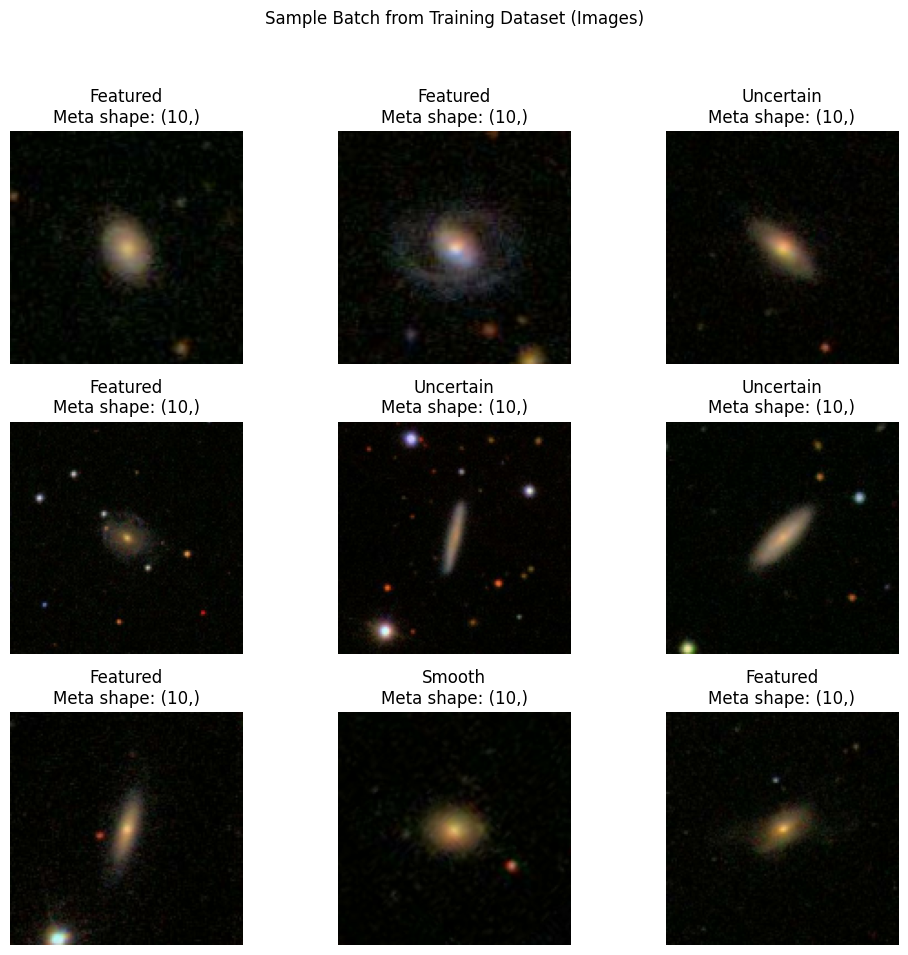

In [4]:
def load_and_preprocess_image(path):
    """Loads, decodes, resizes, and normalizes an image."""
    try:
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        image = image / 255.0
        return image
    except Exception as e:
        tf.print(f"Error processing image {path}: {e}")
        return tf.zeros([IMG_HEIGHT, IMG_WIDTH, 3]) # Return zeros on error

def preprocess_data_multi(image_path, metadata, label):
    """Loads image and combines it with metadata for the model input."""
    image = load_and_preprocess_image(image_path)
    # Return a tuple structure matching the model's expected inputs
    return (image, metadata), label

# Create training dataset
# Combine paths and metadata into one dataset structure first
train_ds_inputs = tf.data.Dataset.from_tensor_slices((X_train_paths, X_train_meta))
train_ds_labels = tf.data.Dataset.from_tensor_slices(y_train)
# Zip the inputs and labels together
train_dataset = tf.data.Dataset.zip((train_ds_inputs, train_ds_labels))

# Now map the preprocessing function
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_paths))
train_dataset = train_dataset.map(
    lambda inputs, label: preprocess_data_multi(inputs[0], inputs[1], label),
    num_parallel_calls=AUTOTUNE
)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Create validation dataset (similar process)
val_ds_inputs = tf.data.Dataset.from_tensor_slices((X_val_paths, X_val_meta))
val_ds_labels = tf.data.Dataset.from_tensor_slices(y_val)
val_dataset = tf.data.Dataset.zip((val_ds_inputs, val_ds_labels))

val_dataset = val_dataset.map(
    lambda inputs, label: preprocess_data_multi(inputs[0], inputs[1], label),
    num_parallel_calls=AUTOTUNE
)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

print("\nTensorFlow datasets for multi-modal input created.")
print("Training dataset spec:", train_dataset.element_spec)
print("Validation dataset spec:", val_dataset.element_spec)

# Optional: Visualize a batch (only shows image part)
print("\nVisualizing sample batch (image only)...")
plt.figure(figsize=(10, 10))
# Note: Accessing elements requires careful indexing due to nested structure
for (images, metadata_batch), labels in train_dataset.take(1):
    for i in range(min(9, BATCH_SIZE)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        label_index = np.argmax(labels[i].numpy())
        plt.title(f"{label_encoder.classes_[label_index]}\nMeta shape: {metadata_batch[i].shape}")
        plt.axis("off")
plt.suptitle("Sample Batch from Training Dataset (Images)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
plt.show()

In [5]:
def build_multimodal_model(img_shape, num_meta_features, num_classes):
    # --- Image Input Branch (CNN) ---
    image_input = Input(shape=img_shape, name="image_input")
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    cnn_output = Flatten(name="flatten_image")(x)

    # --- Metadata Input Branch (Dense) ---
    meta_input = Input(shape=(num_meta_features,), name="meta_input")
    y = Dense(64, activation="relu")(meta_input)
    y = BatchNormalization()(y)
    y = Dropout(0.3)(y)
    meta_output = Dense(32, activation="relu")(y)

    # --- Concatenate Branches ---
    combined = concatenate([cnn_output, meta_output], name="concatenate_features")

    # --- Final Classifier Head ---
    z = Dense(128, activation="relu")(combined)
    z = BatchNormalization()(z)
    z = Dropout(0.5)(z)
    output = Dense(num_classes, activation="softmax", name="output")(z)

    # --- Create and Compile Model ---
    model = Model(inputs=[image_input, meta_input], outputs=output)
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Define input shapes
image_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# Build the model
model = build_multimodal_model(image_shape, NUM_METADATA_FEATURES, NUM_CLASSES)

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
print("\nStarting multi-modal model training...")

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1,
)

print("\nTraining finished.")



Starting multi-modal model training...
Epoch 1/15
5990/5990 [==============================] - 96s 15ms/step - loss: 0.7668 - accuracy: 0.6400 - val_loss: 0.8532 - val_accuracy: 0.5864
Epoch 2/15
5990/5990 [==============================] - 90s 15ms/step - loss: 0.6738 - accuracy: 0.6824 - val_loss: 0.7234 - val_accuracy: 0.6621
Epoch 3/15
5990/5990 [==============================] - 90s 15ms/step - loss: 0.6385 - accuracy: 0.7002 - val_loss: 0.6718 - val_accuracy: 0.6791
Epoch 4/15
5990/5990 [==============================] - 91s 15ms/step - loss: 0.6200 - accuracy: 0.7092 - val_loss: 0.8925 - val_accuracy: 0.5820
Epoch 5/15
5990/5990 [==============================] - 92s 15ms/step - loss: 0.6060 - accuracy: 0.7155 - val_loss: 0.5844 - val_accuracy: 0.7264
Epoch 6/15
5990/5990 [==============================] - 92s 15ms/step - loss: 0.5931 - accuracy: 0.7226 - val_loss: 0.6027 - val_accuracy: 0.7160
Epoch 7/15
5990/5990 [==============================] - 93s 15ms/step - loss: 0.5786


Evaluating model on validation data...
Validation Loss: 0.6719
Validation Accuracy: 0.7009


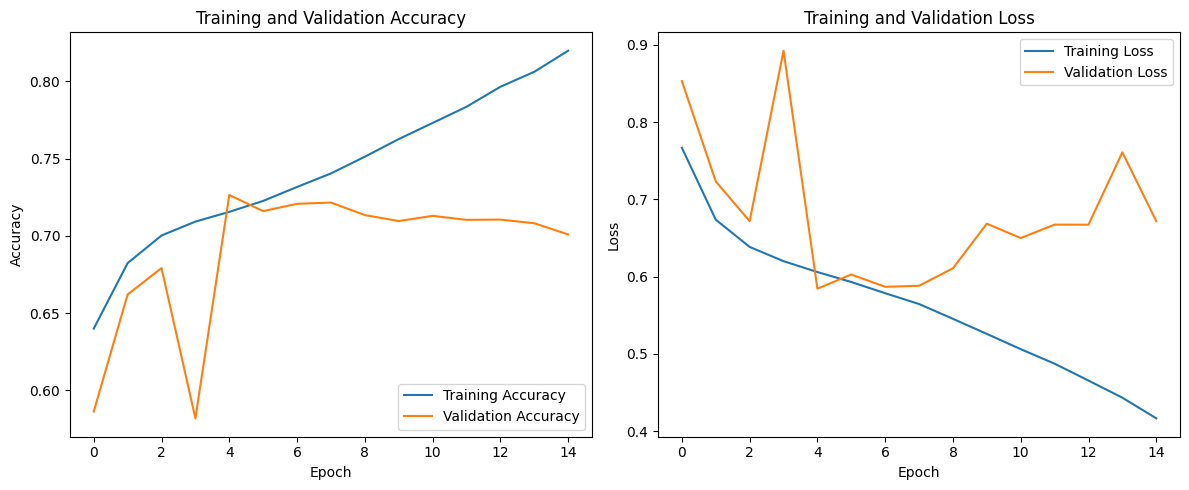

In [7]:
# Evaluate the model on the validation set
print("\nEvaluating model on validation data...")
loss, accuracy = model.evaluate(val_dataset, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot training history
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()


Generating Saliency Maps manually using tf.GradientTape...
  Generating maps for class: Featured (index 0)
    Saved map to explainability_maps\manual_vanilla_gradients_Featured.png
  Generating maps for class: Smooth (index 1)
    Saved map to explainability_maps\manual_vanilla_gradients_Smooth.png
  Generating maps for class: Uncertain (index 2)
    Saved map to explainability_maps\manual_vanilla_gradients_Uncertain.png

Manual explanation generation complete.
Check the 'explainability_maps' directory.


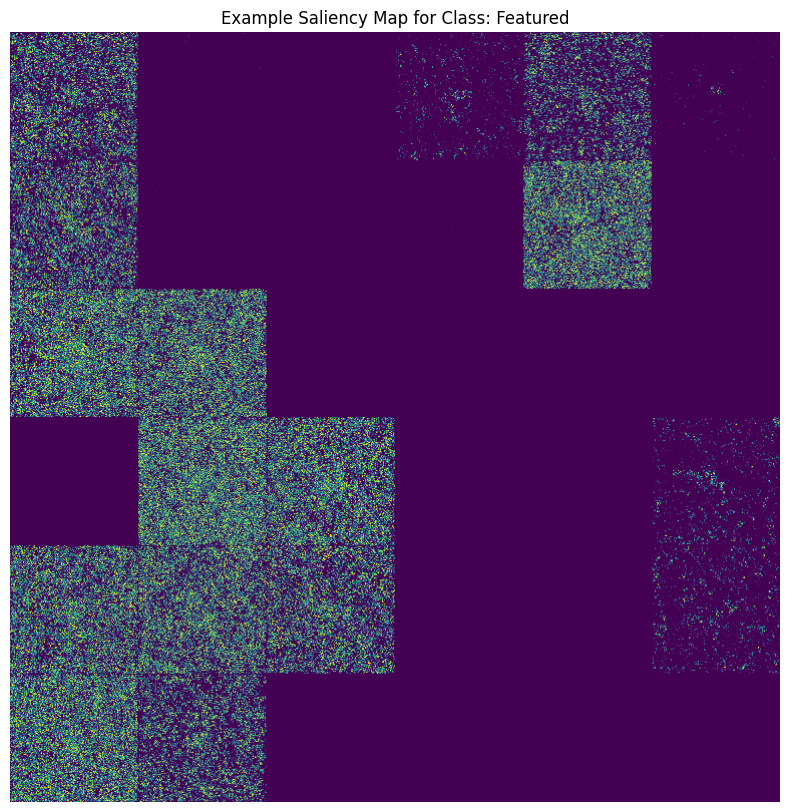

In [8]:
print("\nGenerating Saliency Maps manually using tf.GradientTape...")

# Ensure output directory exists
os.makedirs(EXPLAIN_OUTPUT_DIR, exist_ok=True)

# Get a batch of validation data (images, metadata, labels)
(val_images_explain, val_meta_explain), val_labels_explain_onehot = next(iter(val_dataset))
# val_labels_explain_int = np.argmax(val_labels_explain_onehot.numpy(), axis=1) # Not needed for gradient calc

# Cast image data to ensure it's float32 for gradient tape
val_images_explain_tf = tf.cast(val_images_explain, tf.float32)
# Metadata should already be float from StandardScaler
val_meta_explain_tf = tf.cast(val_meta_explain, tf.float32)


# Generate explanations for each class
for class_index, class_name in enumerate(label_encoder.classes_):
    print(f"  Generating maps for class: {class_name} (index {class_index})")

    with tf.GradientTape() as tape:
        # Watch the image tensor, as we want gradients w.r.t. pixels
        tape.watch(val_images_explain_tf)

        # Get model predictions - IMPORTANT: provide inputs as a list/tuple
        # Also set training=False for inference mode (affects BatchNormalization, Dropout)
        predictions = model([val_images_explain_tf, val_meta_explain_tf], training=False)

        # Get the scores for the specific class we are interested in
        class_scores = predictions[:, class_index]

    # Calculate gradients of the class score w.r.t. the input image pixels
    gradients = tape.gradient(class_scores, val_images_explain_tf)

    if gradients is None:
        print(f"    WARNING: Gradients are None for class {class_name}. Skipping.")
        continue

    # Process gradients: absolute value, then normalize to grayscale [0, 255]
    # This matches tf-explain's typical processing for visualization
    grayscale_gradients = transform_to_normalized_grayscale(
        tf.abs(gradients) # Take absolute value
    ).numpy()

    # Create a grid display of the gradients using tf-explain's utility
    # This function arranges the batch of gradient maps into a single image grid
    grid = grid_display(grayscale_gradients)

    # Save the generated grid image
    save_path = os.path.join(EXPLAIN_OUTPUT_DIR, f"manual_vanilla_gradients_{class_name}.png")
    # Use matplotlib to save the numpy array as an image
    plt.imsave(save_path, grid, cmap='viridis') # Or use default cmap
    print(f"    Saved map to {save_path}")

print("\nManual explanation generation complete.")
print(f"Check the '{EXPLAIN_OUTPUT_DIR}' directory.")

# Display one of the generated maps (optional)
try:
    example_map_path = os.path.join(EXPLAIN_OUTPUT_DIR, f"manual_vanilla_gradients_{label_encoder.classes_[0]}.png")
    if os.path.exists(example_map_path):
        img = plt.imread(example_map_path)
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        plt.title(f"Example Saliency Map for Class: {label_encoder.classes_[0]}")
        plt.axis('off')
        plt.show()
except Exception as e:
    print(f"Could not display example map: {e}")


--- Reimplemented Metadata Feature Explainability ---

Selecting 1000 metadata samples to explain...

Calculating feature importance via permutation method...
Original accuracy on selected samples: 0.7030
  Permuting feature: PETROR50_R
    Accuracy drop: -0.0030
  Permuting feature: PETROR90_R
    Accuracy drop: 0.0070
  Permuting feature: FRACDEV_R
    Accuracy drop: -0.0080
  Permuting feature: REDSHIFT
    Accuracy drop: 0.0440
  Permuting feature: PETROMAG_MU
    Accuracy drop: 0.0040
  Permuting feature: PETROMAG_MG
    Accuracy drop: 0.0270
  Permuting feature: PETROMAG_MR
    Accuracy drop: 0.0200
  Permuting feature: PETROMAG_MI
    Accuracy drop: 0.0100
  Permuting feature: PETROMAG_MZ
    Accuracy drop: 0.0080
  Permuting feature: PETROR50_R_KPC
    Accuracy drop: 0.0570

--- Feature Importance Results ---
          feature  importance
9  PETROR50_R_KPC       0.057
3        REDSHIFT       0.044
5     PETROMAG_MG       0.027
6     PETROMAG_MR       0.020
7     PETROMAG_MI   

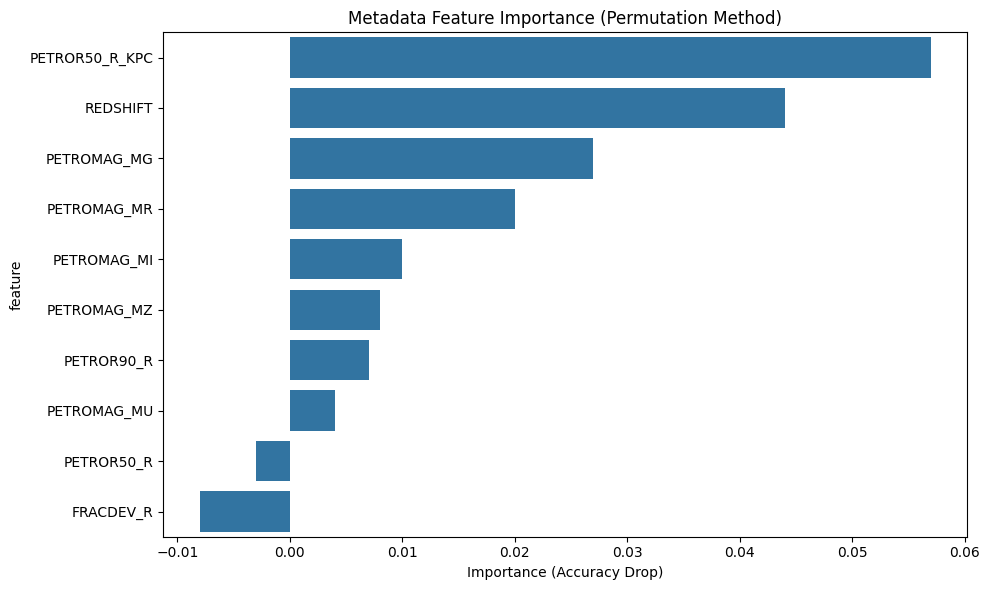


Calculating per-class feature importance...

  Class: Featured
    Top features for Featured:
       feature  importance
0   PETROR50_R    0.015982
7  PETROMAG_MI    0.011416
1   PETROR90_R    0.009132

  Class: Smooth
    Top features for Smooth:
       feature  importance
6  PETROMAG_MR    0.077869
5  PETROMAG_MG    0.065574
3     REDSHIFT    0.049180

  Class: Uncertain
    Top features for Uncertain:
          feature  importance
9  PETROR50_R_KPC    0.047170
2       FRACDEV_R    0.040881
0      PETROR50_R    0.034591


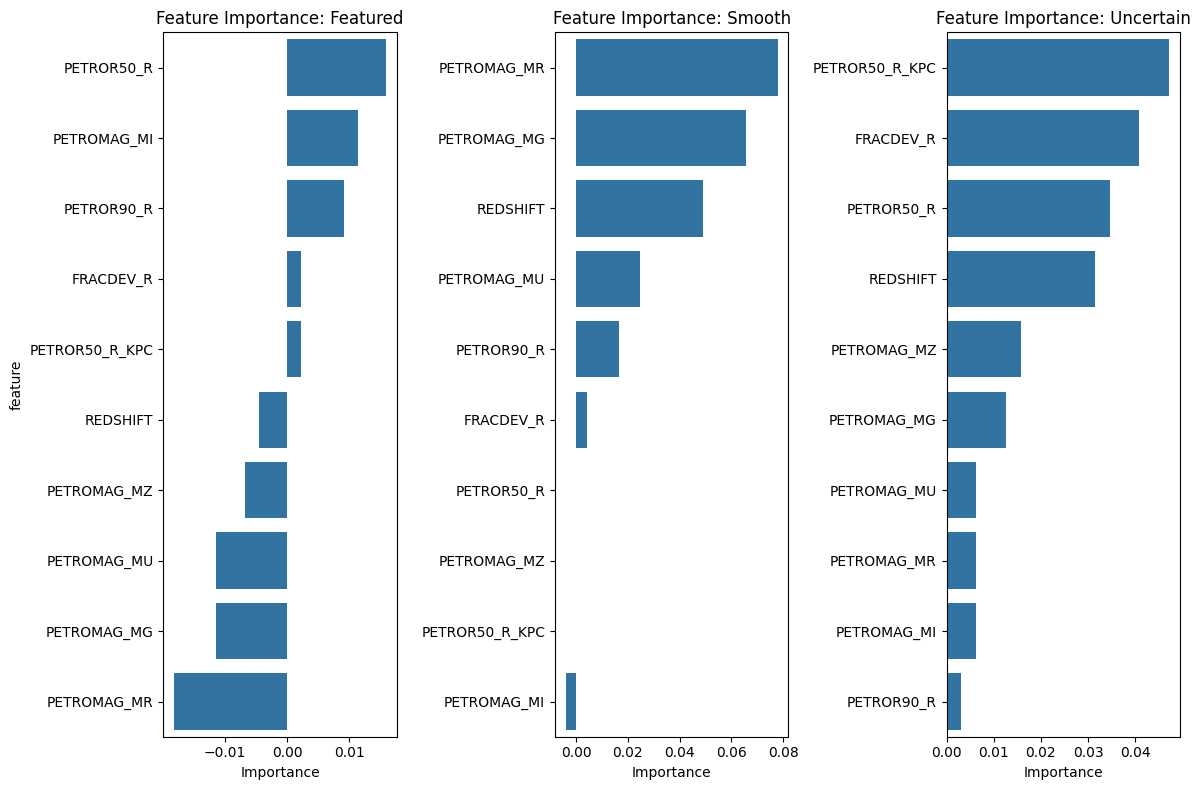


Analyzing feature correlations with class predictions...
Getting predictions for all validation data...


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [9]:
print("\n--- Reimplemented Metadata Feature Explainability ---")

# --- Sample Selection ---
N_EXPLAIN_SAMPLES = 1000
print(f"\nSelecting {N_EXPLAIN_SAMPLES} metadata samples to explain...")
explain_indices = np.random.choice(len(X_val_meta), N_EXPLAIN_SAMPLES, replace=False)
meta_to_explain = X_val_meta[explain_indices]
img_to_explain = np.array([load_and_preprocess_image(X_val_paths[i]).numpy() for i in explain_indices])
labels_to_explain = y_val[explain_indices]
label_indices = np.argmax(labels_to_explain, axis=1)

# --- Feature Importance via Permutation ---
print("\nCalculating feature importance via permutation method...")

# Store original predictions
original_preds = model.predict([img_to_explain, meta_to_explain], verbose=0)
original_accuracy = np.mean(np.argmax(original_preds, axis=1) == np.argmax(labels_to_explain, axis=1))
print(f"Original accuracy on selected samples: {original_accuracy:.4f}")

# Calculate importance for each feature
feature_importance = np.zeros(len(METADATA_COLS))

for i, feature_name in enumerate(METADATA_COLS):
    print(f"  Permuting feature: {feature_name}")
    
    # Create a copy of the metadata
    permuted_meta = meta_to_explain.copy()
    
    # Permute the feature (shuffle values across samples)
    permuted_values = np.random.permutation(permuted_meta[:, i])
    permuted_meta[:, i] = permuted_values
    
    # Get predictions with permuted feature
    permuted_preds = model.predict([img_to_explain, permuted_meta], verbose=0)
    permuted_accuracy = np.mean(np.argmax(permuted_preds, axis=1) == np.argmax(labels_to_explain, axis=1))
    
    # Importance = drop in accuracy
    importance = original_accuracy - permuted_accuracy
    feature_importance[i] = importance
    print(f"    Accuracy drop: {importance:.4f}")

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    'feature': METADATA_COLS,
    'importance': feature_importance
})
importance_df = importance_df.sort_values('importance', ascending=False)

print("\n--- Feature Importance Results ---")
print(importance_df)

# --- Visualize Feature Importance ---
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Metadata Feature Importance (Permutation Method)')
plt.xlabel('Importance (Accuracy Drop)')
plt.tight_layout()
plt.savefig(os.path.join(EXPLAIN_OUTPUT_DIR, 'metadata_feature_importance.png'))
plt.show()

# --- Per-Class Feature Importance ---
print("\nCalculating per-class feature importance...")

# Initialize array to store class-specific importance
class_importance = np.zeros((NUM_CLASSES, len(METADATA_COLS)))

for class_idx in range(NUM_CLASSES):
    class_name = label_encoder.classes_[class_idx]
    print(f"\n  Class: {class_name}")
    
    # Get samples of this class
    class_samples = np.where(np.argmax(labels_to_explain, axis=1) == class_idx)[0]
    
    if len(class_samples) < 5:  # Skip if too few samples
        print(f"    Not enough samples for class {class_name}. Skipping.")
        continue
        
    class_meta = meta_to_explain[class_samples]
    class_img = img_to_explain[class_samples]
    class_labels = labels_to_explain[class_samples]
    
    # Original predictions and accuracy for this class
    class_preds = model.predict([class_img, class_meta], verbose=0)
    class_accuracy = np.mean(np.argmax(class_preds, axis=1) == class_idx)
    
    # Calculate importance for each feature for this class
    for i, feature_name in enumerate(METADATA_COLS):
        # Create a copy and permute the feature
        permuted_meta = class_meta.copy()
        permuted_meta[:, i] = np.random.permutation(permuted_meta[:, i])
        
        # Get predictions with permuted feature
        permuted_preds = model.predict([class_img, permuted_meta], verbose=0)
        permuted_accuracy = np.mean(np.argmax(permuted_preds, axis=1) == class_idx)
        
        # Importance = drop in accuracy
        importance = class_accuracy - permuted_accuracy
        class_importance[class_idx, i] = importance
        
    # Print top features for this class
    class_imp_df = pd.DataFrame({
        'feature': METADATA_COLS,
        'importance': class_importance[class_idx]
    }).sort_values('importance', ascending=False)
    
    print(f"    Top features for {class_name}:")
    print(class_imp_df.head(3))

# --- Visualize Per-Class Feature Importance ---
plt.figure(figsize=(12, 8))
for class_idx in range(NUM_CLASSES):
    plt.subplot(1, NUM_CLASSES, class_idx + 1)
    class_imp_df = pd.DataFrame({
        'feature': METADATA_COLS,
        'importance': class_importance[class_idx]
    }).sort_values('importance', ascending=False)
    
    sns.barplot(x='importance', y='feature', data=class_imp_df)
    plt.title(f'Feature Importance: {label_encoder.classes_[class_idx]}')
    plt.xlabel('Importance')
    if class_idx > 0:
        plt.ylabel('')
    
plt.tight_layout()
plt.savefig(os.path.join(EXPLAIN_OUTPUT_DIR, 'per_class_feature_importance.png'))
plt.show()

# --- Feature Correlation with Predictions ---
print("\nAnalyzing feature correlations with class predictions...")

# Create a DataFrame with metadata features and model predictions
meta_pred_df = pd.DataFrame(X_val_meta, columns=METADATA_COLS)

# Get predictions for all validation data
print("Getting predictions for all validation data...")
# Load all validation images (this might be memory-intensive)
val_images = np.array([load_and_preprocess_image(path).numpy() for path in X_val_paths])
all_val_preds = model.predict([val_images, X_val_meta], verbose=0)
all_val_pred_classes = np.argmax(all_val_preds, axis=1)
all_val_true_classes = np.argmax(y_val, axis=1)

# Add prediction info to DataFrame
meta_pred_df['predicted_class'] = all_val_pred_classes
meta_pred_df['true_class'] = all_val_true_classes
meta_pred_df['correct_prediction'] = (meta_pred_df['predicted_class'] == meta_pred_df['true_class']).astype(int)

# Calculate correlation between features and correct predictions
correlation = meta_pred_df[METADATA_COLS].corrwith(meta_pred_df['correct_prediction'])

print("\n--- Feature Correlation with Correct Predictions ---")
correlation_df = pd.DataFrame({
    'feature': correlation.index,
    'correlation': correlation.values
}).sort_values('correlation', ascending=False)
print(correlation_df)

# Visualize correlation
plt.figure(figsize=(10, 6))
sns.barplot(x='correlation', y='feature', data=correlation_df)
plt.title('Feature Correlation with Correct Predictions')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.savefig(os.path.join(EXPLAIN_OUTPUT_DIR, 'feature_correlation.png'))
plt.show()

# --- Feature Distribution by Class ---
print("\nVisualizing feature distributions by class...")

# Map class indices to names for better visualization
class_names = {i: name for i, name in enumerate(label_encoder.classes_)}
meta_pred_df['true_class_name'] = meta_pred_df['true_class'].map(class_names)

# Select top 3 most important features
top_features = importance_df['feature'].head(3).tolist()

plt.figure(figsize=(15, 5 * len(top_features)))
for i, feature in enumerate(top_features):
    plt.subplot(len(top_features), 1, i+1)
    
    # Plot distribution for each class
    for class_idx, class_name in enumerate(label_encoder.classes_):
        class_data = meta_pred_df[meta_pred_df['true_class'] == class_idx][feature]
        if len(class_data) > 0:  # Only plot if we have data
            sns.kdeplot(class_data, label=class_name)
    
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(EXPLAIN_OUTPUT_DIR, 'feature_distributions.png'))
plt.show()

# --- Feature Importance Heatmap ---
print("\nCreating feature importance heatmap across classes...")

# Create a heatmap of feature importance by class
plt.figure(figsize=(12, 8))
heatmap_df = pd.DataFrame(class_importance, columns=METADATA_COLS)
heatmap_df.index = label_encoder.classes_
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.3f')
plt.title('Feature Importance by Class')
plt.ylabel('Class')
plt.xlabel('Metadata Feature')
plt.tight_layout()
plt.savefig(os.path.join(EXPLAIN_OUTPUT_DIR, 'feature_importance_heatmap.png'))
plt.show()

print("\nMetadata feature explainability analysis complete.")

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime

# We'll re-use the same image_paths from your final_df. 
# If you want to combine unlabeled images, you could do so here.
all_unlabeled_image_paths = final_df["image_path"].values

# (Optional) If you have more unlabeled data than labeled, you can mix them in.
# For now, we just assume all_unlabeled_image_paths has the galaxies you want to use for self-supervision.

# -----------------------------
# Create a Dataset for SimCLR
# -----------------------------

# We create two augmented "views" of the same image for contrastive learning.
def random_augmentation(image):
    """Applies heavy random augmentations for contrastive learning."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    # Random crop + resize back to original size
    # We'll pick a random fraction of area to crop.
    crop_fraction = tf.random.uniform([], 0.7, 1.0)  # e.g., between 70% - 100% of area
    original_shape = tf.shape(image)
    cropped = tf.image.random_crop(
        image, 
        size=[
            tf.cast(crop_fraction * tf.cast(original_shape[0], tf.float32), tf.int32),
            tf.cast(crop_fraction * tf.cast(original_shape[1], tf.float32), tf.int32),
            3
        ]
    )
    cropped = tf.image.resize(cropped, [IMG_HEIGHT, IMG_WIDTH])
    
    # Random color jitter
    cropped = tf.image.random_brightness(cropped, max_delta=0.2)
    cropped = tf.image.random_contrast(cropped, lower=0.5, upper=1.5)
    cropped = tf.image.random_saturation(cropped, lower=0.5, upper=1.5)
    
    # Optionally random hue shift
    cropped = tf.image.random_hue(cropped, max_delta=0.2)
    
    return cropped

def simclr_augmentations(path):
    """Given an image path, load and return two augmented 'views'."""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    
    # Create two augmented versions
    image1 = random_augmentation(image)
    image2 = random_augmentation(image)
    return (image1, image2)

# Build a dataset of unlabeled images
ssl_dataset = tf.data.Dataset.from_tensor_slices(all_unlabeled_image_paths)
ssl_dataset = ssl_dataset.shuffle(buffer_size=len(all_unlabeled_image_paths))
ssl_dataset = ssl_dataset.map(simclr_augmentations, num_parallel_calls=tf.data.AUTOTUNE)
ssl_dataset = ssl_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
from tensorflow.keras import layers, models

# --------------------------------------------------
# 2.1. Encoder (backbone)
# --------------------------------------------------
def build_encoder(base_width=32):
    """A small CNN encoder for demonstration."""
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = layers.Conv2D(base_width, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(base_width*2, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    # Final embedding
    outputs = layers.Lambda(lambda z: tf.math.l2_normalize(z, axis=1))(x)
    
    return models.Model(inputs, outputs, name="simclr_encoder")

# --------------------------------------------------
# 2.2. Projection Head 
# --------------------------------------------------
def build_projection_head(base_model_output_dim=128, projection_dim=64):
    """A small MLP on top of the encoder output for contrastive projection."""
    inputs = layers.Input(shape=(base_model_output_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(projection_dim)(x)
    outputs = layers.Lambda(lambda z: tf.math.l2_normalize(z, axis=1))(x)
    
    return models.Model(inputs, outputs, name="projection_head")

# --------------------------------------------------
# 2.3. Full SimCLR Model
# --------------------------------------------------
def build_simclr_model():
    encoder = build_encoder()
    projection_head = build_projection_head(base_model_output_dim=128, 
                                            projection_dim=64)
    
    # We have two inputs (two augmented views)
    input_1 = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="view_1")
    input_2 = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="view_2")
    
    # Encode each view
    rep_1 = encoder(input_1)
    rep_2 = encoder(input_2)
    
    # Project each view
    proj_1 = projection_head(rep_1)
    proj_2 = projection_head(rep_2)
    
    # We output both
    return models.Model(inputs=[input_1, input_2], outputs=[proj_1, proj_2], name="simclr_model")

# --------------------------------------------------
# 2.4. NT-Xent Loss
# --------------------------------------------------
@tf.function
def nt_xent_loss(proj_1, proj_2, temperature=0.1):
    """Compute the normalized temperature-scaled cross-entropy loss (NT-Xent).
    proj_1, proj_2: [batch_size, projection_dim]
    """
    # Combine the representations
    batch_size = tf.shape(proj_1)[0]
    z = tf.concat([proj_1, proj_2], axis=0)  # shape [2*batch_size, proj_dim]
    
    # z * z^T gives pairwise similarities
    sim = tf.matmul(z, z, transpose_b=True)  # [2*bs, 2*bs]
    
    # Similarity scaling by temperature
    sim = sim / temperature
    
    # Mask out self-similarities on the diagonal
    mask = tf.eye(2 * batch_size)
    sim = sim - 1e9 * mask  # Large negative to exclude self-sim
    
    # For each row i (representing a sample), the "positive" sample is the one in the other "view".
    # For sample i in [0..bs-1], the positive is i + bs (the matching sample in the second half).
    # For sample i in [bs..2bs-1], the positive is i - bs.
    
    # Indices of positives:
    pos_indices = tf.concat([tf.range(batch_size, 2*batch_size), tf.range(0, batch_size)], axis=0)
    
    # Gather the similarity to the positive
    positives = tf.gather_nd(sim, tf.stack([tf.range(2*batch_size), pos_indices], axis=1))
    
    # The denominator is sum of exponentials of all other samples
    exp_sim = tf.reduce_sum(tf.exp(sim), axis=1)
    
    # The numerator is exp(similarity to the positive)
    numerator = tf.exp(positives)
    
    loss = -tf.reduce_mean(tf.math.log(numerator / exp_sim))
    return loss

In [12]:
encoder = build_encoder()  # ensures (None, 128) output
simclr_model = build_simclr_model() # The actual encoder (build_encoder)
projection_head = simclr_model.layers[2]  # The projection head

# Optimizer
ssl_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

@tf.function
def train_simclr_step(view1, view2):
    with tf.GradientTape() as tape:
        proj1, proj2 = simclr_model([view1, view2], training=True)
        loss = nt_xent_loss(proj1, proj2, temperature=0.1)
    grads = tape.gradient(loss, simclr_model.trainable_variables)
    ssl_optimizer.apply_gradients(zip(grads, simclr_model.trainable_variables))
    return loss

# Hyperparams
SSL_EPOCHS = 50 

for epoch in range(SSL_EPOCHS):
    epoch_loss = []
    for batch in ssl_dataset:
        # batch is ((view1_batch, view2_batch)) from simclr_augmentations
        view1, view2 = batch
        loss_val = train_simclr_step(view1, view2)
        epoch_loss.append(loss_val.numpy())
    print(f"Epoch [{epoch+1}/{SSL_EPOCHS}] - SSL loss: {np.mean(epoch_loss):.4f}")

Epoch [1/50] - SSL loss: 0.9564
Epoch [2/50] - SSL loss: 0.2676
Epoch [3/50] - SSL loss: 0.1936
Epoch [4/50] - SSL loss: 0.1602
Epoch [5/50] - SSL loss: 0.1356
Epoch [6/50] - SSL loss: 0.1219
Epoch [7/50] - SSL loss: 0.1115
Epoch [8/50] - SSL loss: 0.1023
Epoch [9/50] - SSL loss: 0.0970
Epoch [10/50] - SSL loss: 0.0910
Epoch [11/50] - SSL loss: 0.0867
Epoch [12/50] - SSL loss: 0.0823
Epoch [13/50] - SSL loss: 0.0793
Epoch [14/50] - SSL loss: 0.0767
Epoch [15/50] - SSL loss: 0.0741
Epoch [16/50] - SSL loss: 0.0714
Epoch [17/50] - SSL loss: 0.0688
Epoch [18/50] - SSL loss: 0.0669
Epoch [19/50] - SSL loss: 0.0655
Epoch [20/50] - SSL loss: 0.0641
Epoch [21/50] - SSL loss: 0.0625
Epoch [22/50] - SSL loss: 0.0618
Epoch [23/50] - SSL loss: 0.0596
Epoch [24/50] - SSL loss: 0.0588
Epoch [25/50] - SSL loss: 0.0583
Epoch [26/50] - SSL loss: 0.0563
Epoch [27/50] - SSL loss: 0.0564
Epoch [28/50] - SSL loss: 0.0551
Epoch [29/50] - SSL loss: 0.0544
Epoch [30/50] - SSL loss: 0.0533
Epoch [31/50] - SSL

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    BatchNormalization,
    concatenate,
    Flatten
)

def build_multimodal_model_with_pretrained(
    pretrained_encoder, 
    img_shape, 
    num_meta_features, 
    num_classes, 
    trainable_encoder=False
):
    """
    Build your multi-modal model, using a pretrained encoder from SimCLR.
    
    Args:
        pretrained_encoder: tf.keras.Model (the "encoder" part of SimCLR).
        img_shape: shape of the input images.
        num_meta_features: how many metadata features.
        num_classes: number of classes for classification.
        trainable_encoder: bool, if True unfreezes encoder layers for fine-tuning.
    """
    # --- Image Input (Pretrained Encoder) ---
    image_input = Input(shape=img_shape, name="image_input")
    
    # Control encoder trainability
    pretrained_encoder.trainable = trainable_encoder
    
    # pass image_input through pretrained encoder
    x = pretrained_encoder(image_input)
    # If the encoder ends with a normalized embedding, you might want to remove or adapt that layer.
    # In this example, the final layer is L2-normalized. We can simply keep it or add a new Dense.
    x = Dense(128, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    cnn_output = x  # This replaces the old CNN pipeline

    # --- Metadata Input Branch (Dense) ---
    meta_input = Input(shape=(num_meta_features,), name="meta_input")
    y = Dense(64, activation="relu")(meta_input)
    y = BatchNormalization()(y)
    y = Dropout(0.3)(y)
    meta_output = Dense(32, activation="relu")(y)

    # --- Concatenate Branches ---
    combined = concatenate([cnn_output, meta_output], name="concatenate_features")

    # --- Final Classifier Head ---
    z = Dense(128, activation="relu")(combined)
    z = BatchNormalization()(z)
    z = Dropout(0.5)(z)
    output = Dense(num_classes, activation="softmax", name="output")(z)

    # --- Create and Compile Model ---
    model = Model(inputs=[image_input, meta_input], outputs=output)
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Now build the multi-modal model using the pretrained encoder
model_pretrained = build_multimodal_model_with_pretrained(
    pretrained_encoder=encoder,
    img_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_meta_features=NUM_METADATA_FEATURES,
    num_classes=NUM_CLASSES,
    trainable_encoder=True
)

model_pretrained.summary()

# Fine-tune on your labeled train_dataset as before
EPOCHS = 15
history = model_pretrained.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

# Evaluate
loss, accuracy = model_pretrained.evaluate(val_dataset, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 meta_input (InputLayer)        [(None, 10)]         0           []                               
                                                                                                  
 simclr_encoder (Functional)    (None, 128)          8408128     ['image_input[0][0]']            
                                                                                                  
 dense_8 (Dense)                (None, 64)           704         ['meta_input[0][0]']       